# Comparación de datos CHIRPS vs CONAGUA

# Conexión al Repositorio de GitHub

In [1]:
import os
if not os.path.isdir('RecNat-Py'):
    !git clone https://github.com/Diegorb1329/RecNat-Py.git
else:
    print("El repositorio ya ha sido clonado.")

%cd RecNat-Py

!pip install -r Requirements.txt

El repositorio ya ha sido clonado.
/content/RecNat-Py


Crear una carpeta para el almacenamiento temporal de los resultados

In [6]:
nombre_carpeta = "Salidas de prueba"
ruta_carpeta_trabajo = os.path.join("/content/RecNat-Py", nombre_carpeta)
os.makedirs(ruta_carpeta_trabajo, exist_ok=True)

Definición de un municipio de interés para **elegir una estación** a la que realizar la comparación de datos

In [7]:
# Definir el municipio de interés
municipio_interes = "Texcoco"

In [15]:
import geopandas as gpd
import pandas as pd


mun_mex = "/content/RecNat-Py/EMS_CONAGUA/Municipios_Mex/muni_2018gw.shp"
mun_mex = gpd.read_file(mun_mex, encoding='utf-8')
municipio_recortado = mun_mex[mun_mex["NOM_MUN"] == municipio_interes]
nombre_carpeta_municipio = municipio_interes
ruta_carpeta_municipio = os.path.join(ruta_carpeta_trabajo, nombre_carpeta_municipio)
os.makedirs(ruta_carpeta_municipio, exist_ok=True)
ruta_archivo_salida = os.path.join(ruta_carpeta_municipio, f"{municipio_interes}.shp")
municipio_recortado.to_file(ruta_archivo_salida)

print("Shp del municipio guardado en: ", ruta_archivo_salida )

Shp del municipio guardado en:  /content/RecNat-Py/Salidas de prueba/Texcoco/Texcoco.shp


In [16]:
carpeta_datos = "/content/RecNat-Py/EMS_CONAGUA/txts"
df_metadatos = pd.read_csv("/content/RecNat-Py/EMS_CONAGUA/Metadatos/metadatos_final_2.csv")

## Fehcas de inicio y fin del análisis
fecha_inicio = pd.to_datetime("1990-12-01")
fecha_fin = pd.to_datetime("2020-12-31")

Módulo importado correctamente


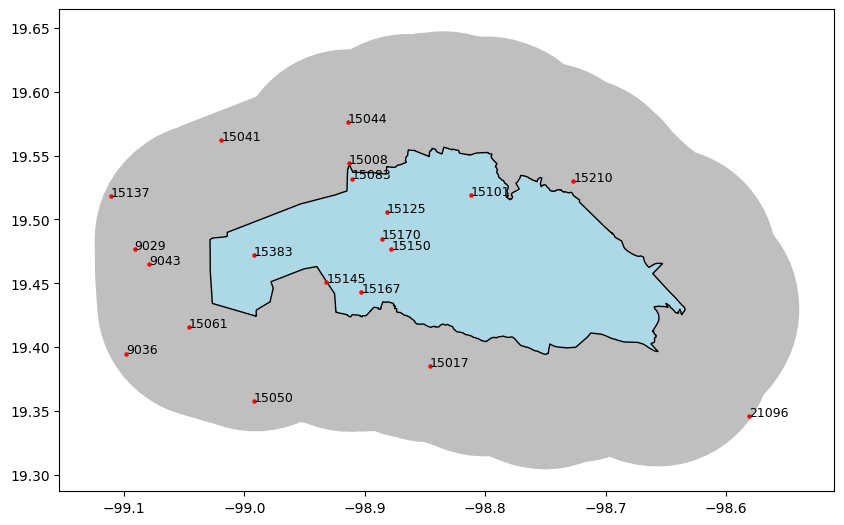

In [18]:
import sys
sys.path.append('/content/RecNat-Py/EMS_CONAGUA/Funciones')

try:
    import funciones_clim_ems as fcems
    print("Módulo importado correctamente")
except ModuleNotFoundError:
    print("No se pudo encontrar el módulo 'funciones_clim_ems'")

fcems.mapa_estaciones (ruta_archivo_salida, df_metadatos, 1 , "14N", True, 10000)

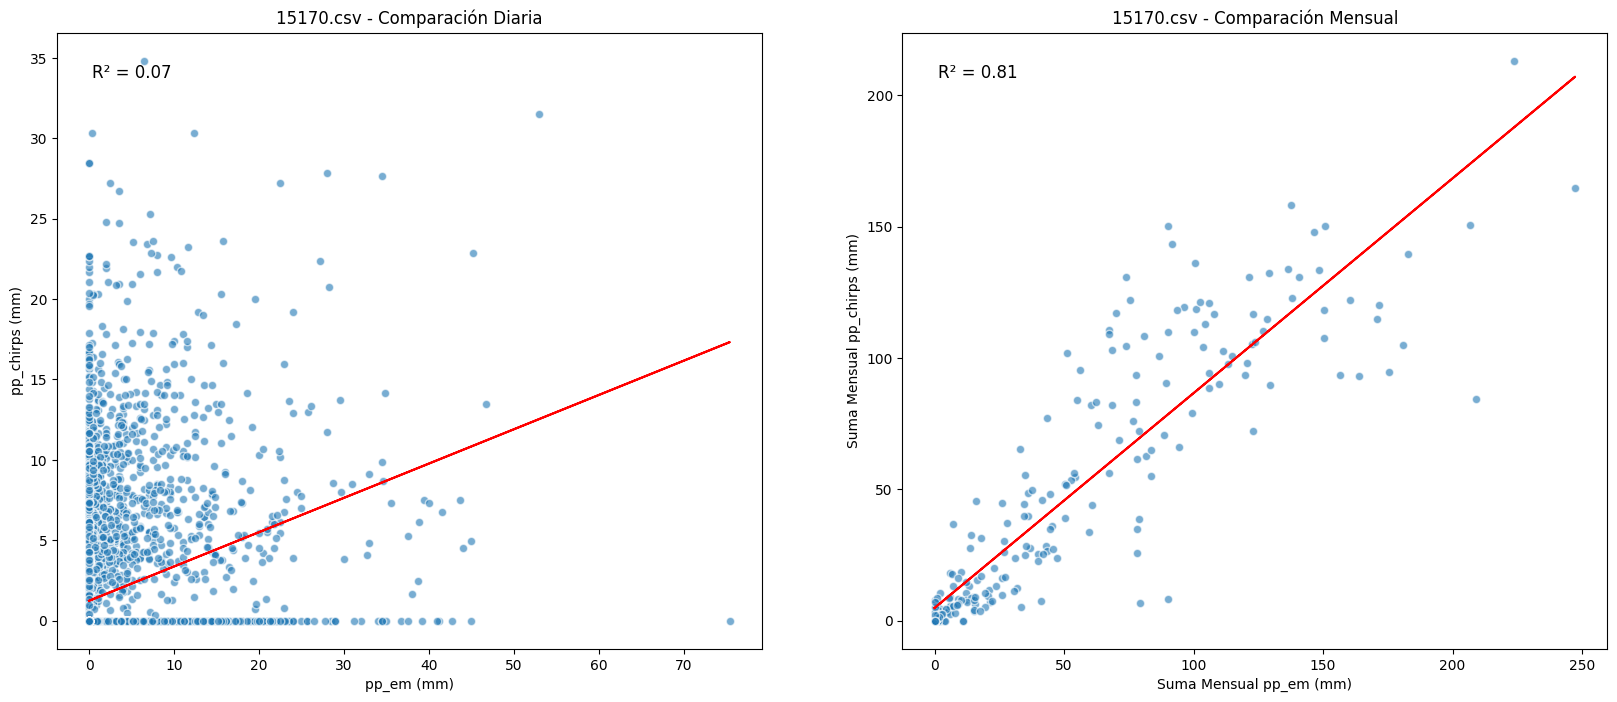

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

def plot_combined_pp_comparison(station_filename):
    folder_path = '/content/RecNat-Py/Varios/CHIRPSvsEM_CONAGUA/precip_merged_data/'
    file_path = folder_path + station_filename

    try:
        data = pd.read_csv(file_path)
        data['Fecha'] = pd.to_datetime(data['Fecha'])

        # Limpieza de datos: Eliminar filas con valores nulos o infinitos
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data.dropna(subset=['pp_em', 'pp_chirps'], inplace=True)

        monthly_data = data.groupby(pd.Grouper(key='Fecha', freq='M')).sum()

        fig, ax = plt.subplots(1, 2, figsize=(20, 8))

        # Diario
        ax[0].scatter(data['pp_em'], data['pp_chirps'], alpha=0.6, edgecolors='w')
        coef = np.polyfit(data['pp_em'], data['pp_chirps'], 1)
        poly1d_fn = np.poly1d(coef)
        r_squared = r2_score(data['pp_chirps'], poly1d_fn(data['pp_em']))
        ax[0].plot(data['pp_em'], poly1d_fn(data['pp_em']), color="red")
        ax[0].text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=ax[0].transAxes, fontsize=12, verticalalignment='top')
        ax[0].set_title(f"{station_filename} - Comparación Diaria")
        ax[0].set_xlabel('pp_em (mm)')
        ax[0].set_ylabel('pp_chirps (mm)')

        # Mensual
        ax[1].scatter(monthly_data['pp_em'], monthly_data['pp_chirps'], alpha=0.6, edgecolors='w')
        coef_m = np.polyfit(monthly_data['pp_em'], monthly_data['pp_chirps'], 1)
        poly1d_fn_m = np.poly1d(coef_m)
        r_squared_m = r2_score(monthly_data['pp_chirps'], poly1d_fn_m(monthly_data['pp_em']))
        ax[1].plot(monthly_data['pp_em'], poly1d_fn_m(monthly_data['pp_em']), color="red")
        ax[1].text(0.05, 0.95, f'R² = {r_squared_m:.2f}', transform=ax[1].transAxes, fontsize=12, verticalalignment='top')
        ax[1].set_title(f"{station_filename} - Comparación Mensual")
        ax[1].set_xlabel('Suma Mensual pp_em (mm)')
        ax[1].set_ylabel('Suma Mensual pp_chirps (mm)')

        plt.show()

    except FileNotFoundError:
        print("El archivo especificado no se encontró en la carpeta designada.")
    except Exception as e:
        print(f"Ocurrió un error al procesar los datos: {e}")

# Ejemplo de cómo llamar a la función
plot_combined_pp_comparison('15170.csv')
